# import 

In [42]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from datetime import timedelta, datetime
import networkx as nx
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

def timerange_day(df):
    oldest = df.iloc[len(df)-1].date
    latest = df.iloc[0].date
    range_list = [str(oldest).split()[0]]
    while range_list[-1] != str(latest).split()[0]:
        oldest = oldest + timedelta(days=1)
        range_list.append(str(oldest).split()[0])
    return pd.DataFrame(range_list, columns=['date'])

In [2]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.csv
badstudent_tweet.json
badstudent_tweet_raw.csv
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv
tanawatofficial_tweet.csv
tanawatofficial_tweet.json
tanawatofficial_tweet_raw.csv
thammasatUFTD_tweet.csv
thammasatUFTD_tweet.json
thammasatUFTD_tweet_raw.csv
แฮมทาโร่.csv
แฮมทาโร่.json
แฮมทาโร่_hashtag.csv
แฮมทาโร่_hashtag_tokenized.json
แฮมทาโร่_tokenized.json
ประเทศกูมี.csv
ประเทศกูมี.json
ประเทศกูมี_tokenized.json
ม็อบมุ้งมิ้ง.csv
แบนแทกุกไลน์.csv
ม็อบมุ้งมิ้ง.json
แบนแทกุกไลน์.json
ม็อบมุ้งมิ้ง_hashtag.csv
แบนแทกุกไลน์_hashtag.

In [2]:
filename = 'tweets/ประเทศกูมี.json'
filename = 'tweets/ถ้าการเมืองดี.json'
#filename = 'tweets/ให้มันจบที่รุ่นเรา.json'
num = 20

# tokenize

In [4]:
df = pd.read_json(filename, lines=True).drop_duplicates('id')
df = df.reset_index(drop=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date < '2021-03-01')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1366070107949002752,1366070107949002752,2021-02-28 16:57:48,2021-02-28,23:57:48,700,1094636499511869441,yeppeunryuna13,; yunaverse #LOCO,,...,,,,,[],,,,,"[มีเรื่อง, ม็อบ, แอนตี้, เหี้ย, บูล, ลี่, ถาโถ..."
1,1366069671208755202,1366067044655849472,2021-02-28 16:56:04,2021-02-28,23:56:04,700,933178265178484738,haveabkppday,🎀มิ้นโน๊ะ🎀,,...,,,,,[],,,,,"[สลิ่ม, ช่าง, กล้า, ช่าง, มั่น, เนอะ, เรื่อง, ..."
2,1366069638627397632,1366069638627397632,2021-02-28 16:55:56,2021-02-28,23:55:56,700,1233000287981334528,kanhom1135,ก้านหอม กู้ดบอย*,,...,,,,,[],,,,,"[การเมือง, ดี, เดี๋ยว, ผัว]"
3,1366069581442211840,1366069581442211840,2021-02-28 16:55:43,2021-02-28,23:55:43,700,1152954640331243526,ddoremeee,ddoreme✨ — 🌷🖇,,...,,,,,[],,,,,"[สื่อ, ทำ, แบบนี้, การเมือง, ดี, ก้คง, ต่อไป, ..."
4,1366069486470631424,1366069486470631424,2021-02-28 16:55:20,2021-02-28,23:55:20,700,1291902052168118273,mdluvbwu,ชาชา III,,...,,,,,[],,,,,"[วก, ด่า, ตำรวจ, ๆๆๆ, การเมือง, ดี]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126036,1212735218617995266,1211557321597313024,2020-01-02 13:59:42,2020-01-02,20:59:42,700,948972629636956161,star75225960,ทิ้งไวกลางทาง,,...,,,,,"[{'screen_name': 'johnwinyu', 'name': 'John Wi...",,,,,"[หมา, ดีกว่า, ตา, ลุง, คน, ลุง, เล่นการเมือง, ..."
126037,1212446213993160704,1212446213993160704,2020-01-01 18:51:18,2020-01-02,01:51:18,700,775321083943591936,khingpitcha,Minny,,...,,,,,[],,,,,"[เกาหลี, สุดยอด, แม่, รู้, ดู, ตะลึง, พระเอก, ..."
126038,1212412674958487552,1212412674958487552,2020-01-01 16:38:01,2020-01-01,23:38:01,700,3265736412,dearmissjanedoe,Jane Doe lll,,...,,,,,[],,,,,"[มุมมอง, เรื่องราว, ได้ดี, เรื่อง, สามัญ, เรื่..."
126039,1212351077653176320,1212351077653176320,2020-01-01 12:33:15,2020-01-01,19:33:15,700,2351874080,swifties378,"19 พฤศจิ—Red(Taylor’s ver.) .|||, ☔︎︎",,...,,,,,[],,,,,"[บ้าน, ดู, เนชั่น, แล้วก็, เมือง, ไทย, อะ, เจร..."


# save

In [5]:
df.to_json(filename.replace('.json','_tokenized.json'), orient='records')

In [6]:
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']
df[column].to_csv(filename.replace('.json','.csv'), index=False)

# frequent hashtag & cooccurent words

In [3]:
df = pd.read_json(filename.replace('.json','_tokenized.json'))


##### hashtags #####
hashtag_counter = Counter()
for lst in tqdm(df.hashtags):
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in tqdm(df.iterrows()):
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|co-hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|#{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

100%|██████████| 126041/126041 [00:00<00:00, 250471.55it/s]
126041it [00:22, 5622.61it/s]


|co-hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|#ถ้าการเมืองดี|47504|ดี(57374) การเมือง(51484) คน(8698) ไม่ต้อง(7421) ประเทศ(5199) ม็อบ(5058) ทำ(4461) ประชาชน(4084) ไทย(3856) แบบนี้(3683)|[2020-07-19 06:20:49](https://twitter.com/InfinitaSub/status/1284734923811590144)<br>[@infinitasub](https://twitter.com/infinitasub)<br><br>เรามาเล่นแทกอะไรกันไหมคะ?   #ถ้าการเมืองดี เราจะมีเงินเดือนที่สูงขึ้น บัตรคอน 5-6-7 พันเหรอ เหอะ! สบายจ้าาาาาาาาาาา|[2020-08-14 02:43:30](https://twitter.com/paolonapaul/status/1294102319664001024)<br>[@paolonapaul](https://twitter.com/paolonapaul)<br>89671 retweets<br><br>ต่อให้รถติด แต่รถสาธารณะต้องไม่ติด  . #เกาหลี #ถ้าการเมืองดี #ขนส่งจะดี #คนเดินเท้า  https://t.co/SrVuemU1Kc|
|#เยาวชนปลดเเอก|2091|ดี(2258) การเมือง(2221) เยาวชน(2129) ปลด(2104) เอก(2100) จบ(824) รุ่น(793) คน(397) พร(355) สู้(303)|[2020-07-18 19:58:48](https://twitter.com/pppsubmarine/status/1284578387952955392)<br>[@pppsubmarine](https://twitter.com/pppsubmarine)<br><br>

# hashtag timeseries

100%|██████████| 7/7 [02:33<00:00, 21.95s/it]


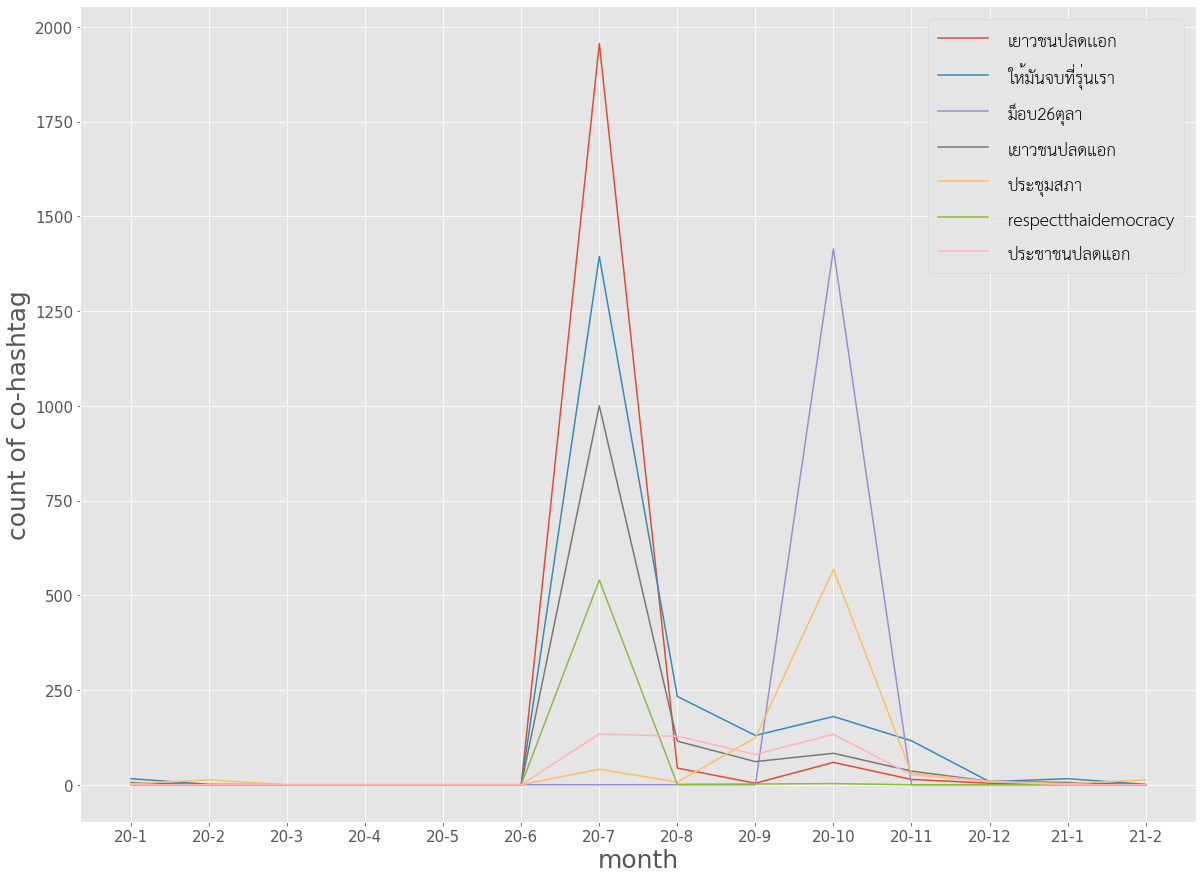

In [15]:
### plot time series ###

start_m = 1
months = [f'20-{m}' for m in range(start_m, 13)] + ['21-1','21-2']

fig = plt.figure(figsize=(20,15))

for tag, count in tqdm(hashtag_counter.most_common(8)[1:]): # exclude original hashtag
    counts = []  
    for y_m in months:
        y = int('20' + y_m.split('-')[0])
        m = int(y_m.split('-')[1])
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(months, counts, label=tag)

plt.xticks(months, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of co-hashtag', size=25)
plt.show()

# LDA

In [5]:
%%time

##### TRAIN #####

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 126041/126041 [00:03<00:00, 37904.18it/s]


CPU times: user 10min 36s, sys: 4.51 s, total: 10min 40s
Wall time: 10min 43s


In [6]:
# Save  & Load

temp_file = datapath(filename.replace('tweets/','').replace('.json',''))
lda.save(temp_file)
#lda = LdaModel.load(temp_file)

In [7]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

|rank|topic 1||topic 2||topic 3||topic 4||topic 5||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|ดี|0.143|การเมือง|0.058|ดี|0.074|ดี|0.078|ดู|0.018|
|2|การเมือง|0.126|ดี|0.050|การเมือง|0.073|การเมือง|0.066|ข่าว|0.018|
|3|เยาวชน|0.035|คน|0.029|ไม่ต้อง|0.031|ซื้อ|0.022|ไทย|0.016|
|4|ประชาชน|0.028|เรื่อง|0.023|กุ|0.017|เดิน|0.016|ด่า|0.014|
|5|เอก|0.024|ทำ|0.014|รถ|0.016|ค่า|0.013|โดน|0.014|
|6|ปลด|0.023|ประเทศ|0.012|นั่ง|0.014|กิน|0.013|ผม|0.014|
|7|จบ|0.020|ดีกว่า|0.011|เหี้ย|0.014|เงิน|0.012|น้อง|0.013|
|8|รุ่น|0.018|ดีขึ้น|0.009|รอ|0.012|แพง|0.011|ทวิ|0.011|
|9|ปลดแอก|0.014|เค้า|0.009|อี|0.012|ราคา|0.010|สลิ่ม|0.010|
|10|ประเทศ|0.011|รู้|0.009|อิ|0.012|ไม่ต้อง|0.010|เล่น|0.010|


In [8]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

,0,1,2,3,4,topic,tweet,date
0,0.057041,0.091768,0.709562,0.090677,0.050953,2,วันนี้มีเรื่องเยอะมาก ทั้งม็อบทั้งแอนตี้เหี้ยท...,2021-02-28 23:00
1,0.000000,0.592653,0.287391,0.052712,0.060728,1,สลิ่มนี่มันช่างกล้าช่างมั่นเนอะ ถ้าพูดเรื่องกา...,2021-02-28 23:00
2,0.041181,0.040648,0.837004,0.040579,0.040587,2,ถ้าการเมืองดีเดี๋ยวกูก็มีผัว,2021-02-28 23:00
3,0.017110,0.456347,0.441584,0.016780,0.068180,1,ถ้าสื่อยังทำแบบนี้ คำว่า”ถ้าการเมืองดี”มันก้คง...,2021-02-28 23:00
4,0.324197,0.028824,0.588911,0.028845,0.029225,2,วกมาด่าตำรวจ เนี่ยๆๆๆ ถ้าการเมืองดีนะ,2021-02-28 23:00
...,...,...,...,...,...,...,...,...
126036,0.129983,0.520507,0.000000,0.095866,0.247113,1,@johnwinyu เชื่อหมายังดีกว่าเชื่อตาลุงคนนี้ ลุ...,2020-01-02 20:00
126037,0.000000,0.460948,0.000000,0.040756,0.486374,4,เกาหลีสุดยอดจ้าแม่ เมื่อก่อนไม่รู้เคยมีมั้ยแต่...,2020-01-02 01:00
126038,0.011156,0.955372,0.011154,0.011154,0.011163,1,ถ้าอยากเข้าใจมุมมองและเรื่องราวต่างๆได้ดี ไม่ว...,2020-01-01 23:00
126039,0.045569,0.843089,0.000000,0.099040,0.000000,1,ที่บ้านดูเนชั่นแล้วก็บอก เมืองไทยอะไม่มีวันเจร...,2020-01-01 19:00


In [84]:
columns = ['date','time','username','tweet','hashtags','topic','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']
pd.concat([df, result_df.topic], axis=1)[columns].to_csv(filename.replace('.json','.csv'), index=False)

In [79]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

|tweet|topic|prob of 1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|ที่เราออกมาเรียกร้องอ่ะ เราไม่ได้คิดแต่ว่าจะให้อนาคตตัวเองดีในวันข้างหน้านะ คือแบบเรามองไปถึง คนตจว. คนพิการ คนแก่ แล้วก็อื่นๆอีกเยอะที่เราเจอในแต่ละวัน คือแบบทำไมพวกเค้าถึงยังเป็นแบบนี้ เวลาเราเห็นละเราช่วยอะไรเค้าไม่ได้นี่แม่งโครตโกรธ #ถ้าการเมืองดี|2|0.111|0.678|0.110|0.093|0.000|
|@skxpusheeeeen แต่มึงพูดอ่ะเป็นอนาคตคูมหมอพูดเรื่องการเมืองกับเรื่องปัญหาสังคมได้นะ มึงแบบรู้เรื่องจริง มึงกับแก๊งๆมึงทุกคน คือ รู้หมด ถ้าไม่รู้เรื่องการเมือง สังคมก็กระหายจะรู้อ่ะ แค่จะพูดหรือไม่พูด ซึ่งดีมากแล้วมึง ประทับจุย 🥺🥺 คุยรู้เรื่อง|2|0.000|0.697|0.068|0.054|0.171|
|เพื่อนบอกอย่าไปเสพข่าวการเมืองเยอะ อย่าด่ารัดทะบานเยอะถ้ามันเอาจริงขึ้นมาเดี๋ยวจะเดือดร้อน อยู่เฉยๆดีกว่า นี่ก็เลิกเลย เลิกคุยกับเพื่อน รู้ว่าอาจจะเป็นห่วงแต่จะให้นิ่งเฉยก็ยังไงอยู่|2|0.000|0.551|0.268|0.000|0.162|
|ถ้าการเมืองดีก็ไม่ต้องทนเดินริมฟุตบาทที่โคตรจะแคบแถมพังอีก ไม่ต้องทนเดินฝ่าน้ำที่ขังเอ่อท่อแบบนี้หรอก รถขับผ่านที่น้ำสาดไปครึ่งตัว ชีวิตดีสัดๆ  https://t.co/4

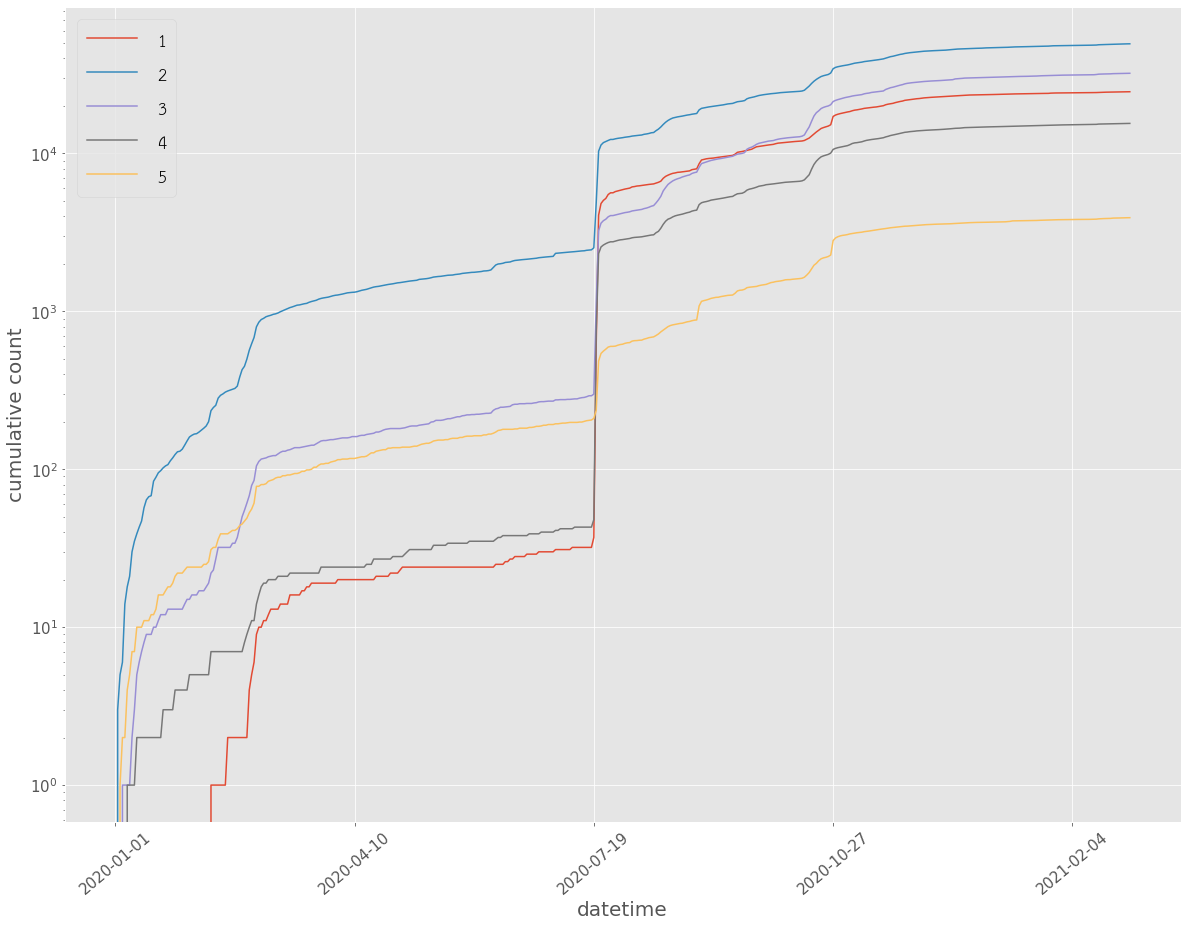

In [31]:
### plot topic time series ###

tempdf = timerange_day(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
fig = tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.yscale('log')

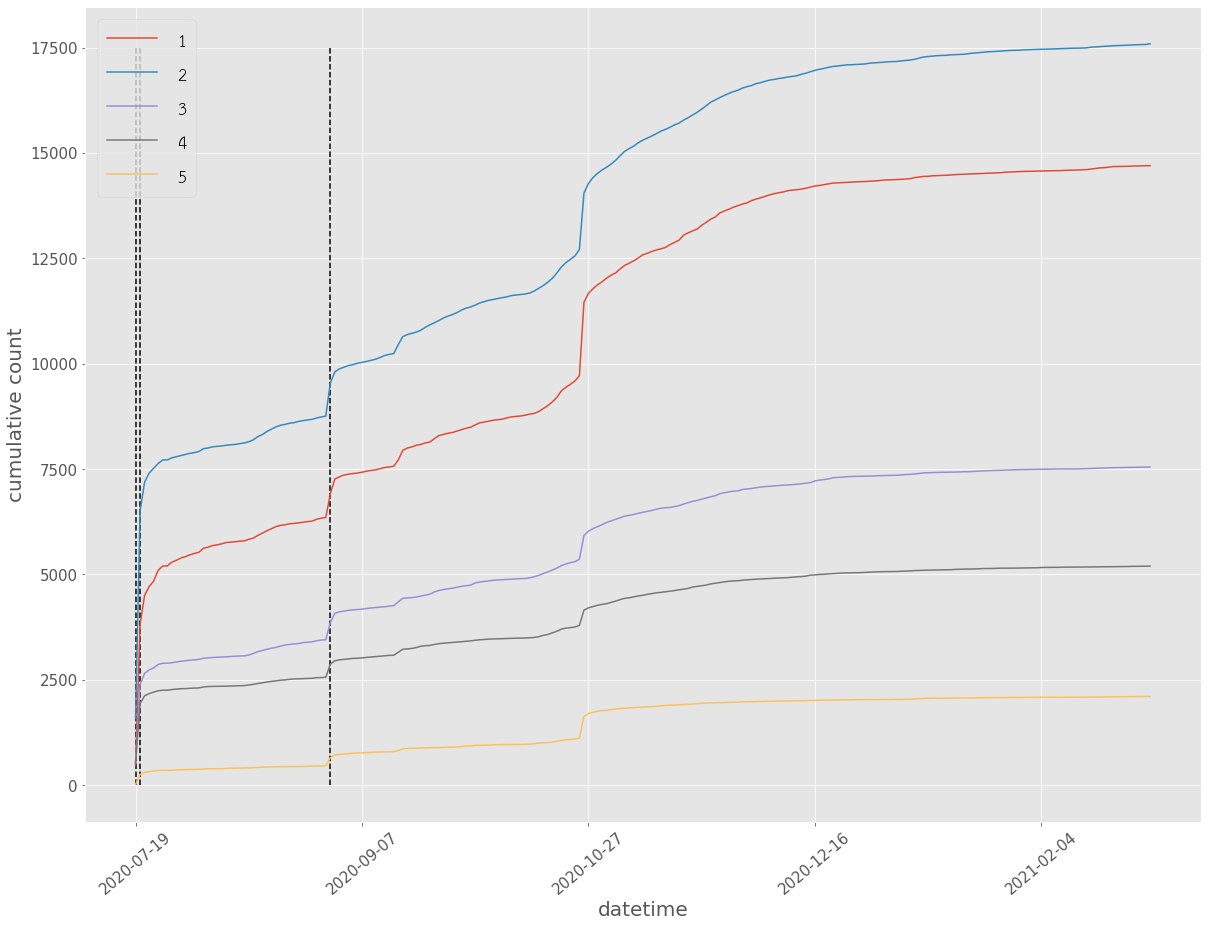

In [112]:
### plot topic time series ###

datedf = timerange_day(tempdf)

for t in range(5):
    datedf[t+1] = datedf.date.apply(lambda x: sum((tempdf.date <= x) & (tempdf.topic==t)))
    
fig = datedf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.vlines([0,1,43], 0, 17500, linestyle="dashed")
#plt.yscale('log')

In [111]:
datedf.max()

date    2021-02-28
1            14700
2            17592
3             7549
4             5198
5             2104
dtype: object

# network

In [96]:
replydf = pd.DataFrame(columns=['replier','replyee','date','time','id'])



"""
### for reply or mention ###
for i, row in df.iterrows():
    for dic in row['reply_to']:
        replydf.loc[len(replydf)] = [row['username'], dic['screen_name']]
"""
        
### for quote_link ###

# hashtag
hashtag = 'ถ้าการเมืองดี'
tempdf = pd.concat([df, result_df.topic], axis=1) # add topic column
tempdf = tempdf[tempdf.hashtags.apply(lambda x: hashtag in x)]

all_link = sorted(tempdf.link)
count = 0
d = set()
for i, row in tqdm(tempdf.iterrows()):
    replier = row['username'] # @paolonapaul
    quote = row['quote_url']
    date_col = row['date']
    time_col = row['time']
    id_col = row['id']
    if quote in all_link:
        count += 1
        replyee = quote.split('/')[3]
        d.add(replyee)
        replydf.loc[len(replydf)] = [replier, replyee, date_col, time_col, id_col]

47143it [02:33, 307.60it/s]


In [98]:
tempdf

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens,topic
26,1366064124782735361,1366064124782735360,2021-02-28 16:34:02,2021-02-28,23:34:02,700,995037931,sweetylifeeiei,🌻𝑵𝒂𝒏𝒇𝒂𝒉🌙ʕ•Ⱉ•⠕ʔ,,...,,,,[],,,,,"[การเมือง, ดี, เค้า, ด่า, ล่ะ, อิ, ควาย, สัก, ...",1
126,1366042210429403151,1366042210429403136,2021-02-28 15:06:57,2021-02-28,22:06:57,700,903137678157160449,bonelesspumpkin,ชิกาปู้: อยากกินซุปเห็ดจ้า,,...,,,,[],,,,,"[การเมือง, ดี, ฟรี, ทีวี, ช่อง, ลงโทษ, ย้อนหลั...",0
208,1366024738766614528,1365941990945214464,2021-02-28 13:57:31,2021-02-28,20:57:31,700,1327966235334561797,oldengine4,Old engine,,...,,,,"[{'screen_name': 'prachatai', 'name': 'prachat...",,,,,"[ตำรวจ, กระสุน, ยาง, ยิง, นักข่าว, การเมือง, ดี]",4
255,1366014299001397249,1366014299001397248,2021-02-28 13:16:02,2021-02-28,20:16:02,700,1269857000923508736,issadiaaa,issadiaaa 🎄,,...,,,,[],,,,,"[การเมือง, อะ, แทบ, ภาครัฐ, กฎหมาย, การบริหาร,...",1
257,1366014041525686273,1366014041525686272,2021-02-28 13:15:01,2021-02-28,20:15:01,700,1142655088663465984,leejstyw28,𝑨𝒖𝒈𝒖𝒔𝒕,,...,,,,[],,,,,"[งง, เหมือนกัน, การเมือง, ชีวิต, เบ๋อ, แง, การ...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122413,1284746129293238275,1284746129293238272,2020-07-19 07:05:21,2020-07-19,14:05:21,700,1260916990991937543,svt_goodboys,แฟนสาวซอกมิน💎💎,,...,,,,[],,,,,"[การเมือง, ดี, เลือก, ประกอบอาชีพ, มากขึ้น, ไม...",1
122419,1284745543286054912,1284745543286054912,2020-07-19 07:03:01,2020-07-19,14:03:01,700,798312685813186560,infinitasub,🏳️‍🌈 Ministry Of INFINITY,,...,,,,[],,,,,"[การเมือง, ดี, เดิน, ถนน, รถ, ส่วนตัว, น้อยลง,...",3
122420,1284745465687191552,1284745465687191552,2020-07-19 07:02:43,2020-07-19,14:02:43,700,443334695,kinc_png,🪴🧸 Kinc📚🌷,,...,,,,[],,,,,"[การเมือง, ดี, หนัง, ดี, ซีรีส์, ดี, ดู, ค่านิ...",0
122437,1284741164575285249,1284741164575285248,2020-07-19 06:45:37,2020-07-19,13:45:37,700,443334695,kinc_png,🪴🧸 Kinc📚🌷,,...,,,,[],,,,,"[การเมือง, ดี, แก้ปัญหา, รถติด, รถติด, แก้, เช...",0


In [52]:
replydf.replyee.value_counts()

KhaosodOnline      110
tanawatofficial    101
wirojlak            78
queentogetheris     67
HAMONY65913323      43
                  ... 
ismilesunflow        1
sq3ne                1
AlwaysonlyYU         1
payayen1             1
lunaxinova           1
Name: replyee, Length: 567, dtype: int64


In [77]:
def make_network(replydf, remove_small=False):
    print(replydf.date.iloc[0], replydf.time.iloc[0])
    
    ### make edge count dictionary ###
    edge_count = Counter()
    node_count = {}  # {node: [replied, reply]}
    
    for  i, j in zip(replydf.replier, replydf.replyee):
        edge_count[(i,j)] += 1
        
        if i not in node_count:
            node_count[i] = [0,1]
        else:
            node_count[i][1] += 1
            
        if j not in node_count:
            node_count[j] = [1,0]
        else:
            node_count[j][0] += 1
    print('----- COUNT FINISHED -----')
    
    ### NETWORK ###
    G = nx.DiGraph()  # Directed Graph

    # add nodes
    for node, tpl in node_count.items():
        if tpl[0] > tpl[1]:
            color = 'lightcoral'
        else:
            color = 'skyblue'
        G.add_node(node, color=color)

    # add edges
    G.add_weighted_edges_from([k+(v,) for k,v in edge_count.items()])

    ### remove small network ###
    if remove_small:
        node_to_remove = set()
        for node, deg in G.degree():
            if deg <= 1:
                neighbor = list(G.predecessors(node)) + list(G.successors(node))
                neighbor_deg = G.degree()(neighbor[0])
                if neighbor_deg == 1:
                    node_to_remove.add(node)
                    node_to_remove.add(neighbor[0])
            elif deg==2 and node in G[node]:
                node_to_remove.add(node)
        for node in node_to_remove:
            G.remove_node(node)
    print('----- REMOVE FINISHED -----')
    
    return nx.nx_agraph.view_pygraphviz(G, prog='fdp') , G

In [78]:
n, G = make_network(replydf.iloc[-1000:], remove_small=True)

2020-08-31 00:00:00 23:24:11
----- COUNT FINISHED -----
----- REMOVE FINISHED -----


In [76]:
'autto002' in n[1]['autto002']

True

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/animation.py", line 1758, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


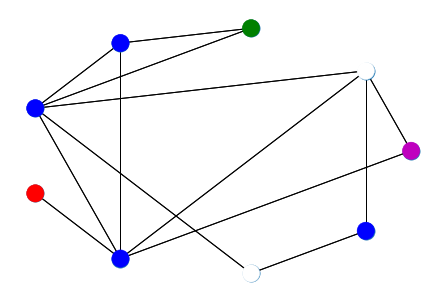

In [90]:
import networkx as nx
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import random

# Graph initialization
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from([(1,2), (3,4), (2,5), (4,5), (6,7), (8,9), (4,7), (1,7), (3,5), (2,7), (5,8), (2,9), (5,7)])

# Animation funciton
def animate(i):
    colors = ['r', 'b', 'g', 'y', 'w', 'm']
    nx.draw_circular(G, node_color=[random.choice(colors) for j in range(9)])

nx.draw_circular(G)
fig = plt.gcf()

# Animator call
anim = animation.FuncAnimation(fig, animate, frames=20, interval=1000, blit=True)